In [24]:
from collections import defaultdict
from typing import List

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import scipy.linalg
import torch
import torch.nn.functional as F
import sklearn.cluster

import datasets
from datasets import load_dataset, set_caching_enabled
from transformers import AutoTokenizer, GPTNeoXForCausalLM

In [2]:
pile_canonical = "/om/user/ericjm/the_pile/the_pile_test_canonical_200k"
# ----- load the_pile test set -----
dataset = datasets.load_from_disk(pile_canonical)

def tokenize_sample(sample):
    tokens = tokenizer(sample["text"], return_tensors='pt', 
                        max_length=1024, truncation=True)["input_ids"]
    return {"input_ids": tokens}

starting_indexes = np.array([0] + list(np.cumsum(dataset["preds_len"])))

def loss_idx_to_dataset_idx(idx):
    """given an idx in range(0, 10658635), return
    a sample index in range(0, 20000) and pred-in-sample
    index in range(0, 1023). Note token-in-sample idx is
    exactly pred-in-sample + 1"""
    sample_index = np.searchsorted(starting_indexes, idx, side="right") - 1
    pred_in_sample_index = idx - starting_indexes[sample_index]
    return int(sample_index), int(pred_in_sample_index)

def get_context(idx):
    """given idx in range(0, 10658635), return dataset sample
    and predicted token index within sample, in range(1, 1024)."""
    sample_index, pred_index = loss_idx_to_dataset_idx(idx)
    return dataset[sample_index], pred_index+1

def print_context(idx, context_length=-1):
    """
    given idx in range(0, 10658635), print prompt preceding the corresponding
    prediction, and highlight the predicted token.
    """
    sample, token_idx = get_context(idx)
    prompt = sample["split_by_token"][:token_idx]
    if context_length > 0:
        prompt = prompt[-context_length:]
    prompt = "".join(prompt)
    token = sample["split_by_token"][token_idx]
    print(prompt + "\033[41m" + token + "\033[0m")

/om2/user/ericjm/miniconda3/envs/phase-changes/lib/python3.8/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [3]:
model_names = [
    "pythia-19m",
    "pythia-125m",
    "pythia-350m",
    "pythia-800m",
    "pythia-1.3b",
    "pythia-2.7b",
    "pythia-6.7b",
    "pythia-13b"
]

In [4]:
curves = np.load("/om/user/ericjm/results/the-everything-machine/pythia-2/pythia-2.npy")

In [5]:
sizes = torch.load("/om/user/ericjm/results/the-everything-machine/pythia-0/num_params.pt")
no_emb_params = [sizes[mn][0] for mn in model_names[:-1]]
with_emb_params = [sizes[mn][2] for mn in model_names[:-1]]

In [6]:
sizes

{'pythia-19m': (18915328, 44670976, 70426624),
 'pythia-125m': (85056000, 123689472, 162322944),
 'pythia-350m': (302311424, 353822720, 405334016),
 'pythia-800m': (805736448, 908759040, 1011781632),
 'pythia-1.3b': (1208602624, 1311625216, 1414647808),
 'pythia-2.7b': (2517652480, 2646430720, 2775208960),
 'pythia-6.7b': (6444163072, 6650732544, 6857302016),
 'pythia-13b': (11327027200, 11586549760, 11846072320)}

### Compute monogenic tokens

In [7]:
monogenic_idxs = defaultdict(list)

aboves = curves > 5.0
belows = curves < 0.3
for j in tqdm([1, 2, 3, 4, 5, 6]):
    aboves_before_j, = np.all(aboves[:, :j], axis=1).nonzero()
    belows_j_and_after, = np.all(belows[:, j:], axis=1).nonzero()
    monogenic_idxs[j] = np.intersect1d(aboves_before_j, belows_j_and_after).tolist()


  0%|          | 0/6 [00:00<?, ?it/s]

In [134]:
def context_tokens(idx, context_length=100, after=0):
    sample, token_idx = get_context(idx)
    prompt = sample["split_by_token"][:token_idx]
    token = sample["split_by_token"][token_idx]
    after_tokens = sample["split_by_token"][token_idx+1:token_idx+1+after]
    return prompt[-context_length:] + [token] + after_tokens

def contains_unicode(text: str) -> bool:
    return any(ord(char) > 127 for char in text)

def tokens_to_latex(tokens: List[str], highlight_index=-1) -> str:
    latex_code = r"\color{lgray}{...}"
    for i, token in enumerate(tokens):
        # choose the text that will go inside the \tok command after {\strut}
        if token == "\n":
            latex_text = r"{\textbackslash}n" # some text that represents a newline
            # latex_text = "↲" # sadly these aren't working
        elif all([c == " " for c in token]):
            latex_text = r"\phantom{" + "a"*len(token) + r"}" # some invisible text that represents a space
        elif token == "\t":
            latex_text = r"\phantom{aaaa}" # some invisible text that represents a tab
        else:
            latex_text = token.replace("_", r"\_").replace("#", r"\#").replace("$", r"\$").replace("%", r"\%").replace("{", r"\{").replace("}", r"\}").replace(r"&", r"\&")
        background_color = "white" if i != highlight_index % len(tokens) else "lightred"
        if i <= highlight_index % len(tokens):
            text_color = "black"
        else:
            text_color = "lgray"
        latex_code += r'\ttok[{}]'.format(background_color) + r'{{\strut}' + r'\color{' + text_color + r'}{' + latex_text + r'}' + r'}'
        latex_code += r'\allowbreak '  # Allow line breaks between tokens
        if token == "\n":
            latex_code += r"\\"
    latex_code += r"\color{lgray}{...}"
    return latex_code

Mounting tensions with Syria sink US stocks

NEW YORK (AP) — Fears of an escalating conflict in Syria rippled across financial markets on Tuesday, sinking stocks, lifting gold and pushing the price of oil to the highest in a year and a half.

The increasing possibility of U.S. military strikes raised worries on Wall Street that energy trade in the region could be disrupted, raising fuel costs for consumers and business.

"If Syria becomes drawn out and becomes a long-term issue, it's going to show up in things like gas prices," said Chris Costanzo, investment officer with Tanglewood Wealth Management.

The Dow Jones industrial average fell 170.33 points, or 1.1 percent, to 14,776.13, the lowest in two months.

The Standard & Poor's 500 index lost 26.30 points, or 1.6 percent, to 1,630.48 and the Nasdaq composite fell 79.05 points, or 2.2 percent, to 3,578.52.

"The law of unintended consequences and the history of previous military interventions in the region is not a recipe for politi

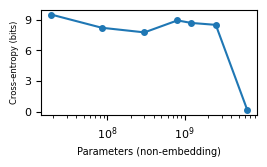

In [135]:
plt.figure(figsize=(2.5, 1.5))

i = 2
idx = monogenic_idxs[6][0]
plt.plot(no_emb_params, curves[idx]/np.log(2), 'o-', markersize=4)
plt.xscale('log')
plt.xlabel("Parameters (non-embedding)", fontsize=7)
plt.ylabel("Cross-entropy (bits)", fontsize=6)
plt.yticks([0, 3, 6, 9], fontsize=8)
plt.xticks(fontsize=8)
print_context(idx)

plt.tight_layout(pad=0.1)
plt.savefig("../figures/tokenscaling/tokenneilmackinnon.pdf")

In [136]:
print(context_tokens(idx, 38))

['"', 'The', ' law', ' of', ' unintended', ' consequences', ' and', ' the', ' history', ' of', ' previous', ' military', ' interventions', ' in', ' the', ' region', ' is', ' not', ' a', ' recipe', ' for', ' political', ' and', ' economic', ' stability', ',"', ' said', ' Neil', ' Mac', 'K', 'inn', 'on', ',', ' global', ' macro', ' strateg', 'ist', ' at', ' V']


In [137]:
before = 38
after = 5
tokens = context_tokens(idx, before, after=after)
text = tokens_to_latex(tokens, -(after+1))
with open("../texts/tokenpile/tokenneilmackinnon.tex", 'w') as f:
    f.write(text)

NEW DELHI: A controversy erupted over the presence of 1984 anti-Sikh riot accused Jagdish Tytler at a Congress event where Sheila Dikshit took charge as party's Delhi chief.Shiromani Akali Dal MLA Manjinder Singh Sir


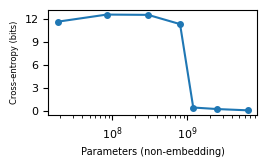

In [138]:
plt.figure(figsize=(2.5, 1.5))

i = 2
idx = monogenic_idxs[4][0]
plt.plot(no_emb_params, curves[idx]/np.log(2), 'o-', markersize=4)
plt.xscale('log')
plt.xlabel("Parameters (non-embedding)", fontsize=7)
plt.ylabel("Cross-entropy (bits)", fontsize=6)
plt.yticks([0, 3, 6, 9, 12], fontsize=8)
plt.xticks(fontsize=8)
print_context(idx)

plt.tight_layout(pad=0.1)
plt.savefig("../figures/tokenscaling/tokensinghsirsa.pdf")

In [139]:
print(context_tokens(idx, 38))

[' accused', ' Jag', 'd', 'ish', ' T', 'yt', 'ler', ' at', ' a', ' Congress', ' event', ' where', ' She', 'ila', ' Di', 'ks', 'hit', ' took', ' charge', ' as', ' party', "'s", ' Delhi', ' chief', '.', 'Sh', 'i', 'rom', 'ani', ' Ak', 'ali', ' Dal', ' M', 'LA', ' Man', 'j', 'inder', ' Singh', ' Sir']


In [140]:
before = 38
after = 5
tokens = context_tokens(idx, before, after=after)
text = tokens_to_latex(tokens, -(after+1))
with open("../texts/tokenpile/tokensinghsirsa.tex", 'w') as f:
    f.write(text)


242 Kan. 875 (1988)
752 P.2d 673
THE CITY OF ARKANSAS CITY, KANSAS, et al., Plaintiffs/Appellees,
v.
A. SCOTT ANDERSON, et al., Defendants,
v.
MID-AMERICA TITLE COMPANY, INC., Garnishee/Defendant, and HESSTON STATE BANK, Interpled Party/Appellant, and THE UNITED STATES OF AMERICA, acting through Farmers Home Administration, Interpled Party.
No. 61,040
Supreme Court of Kansas.
Opinion filed March 25, 1988.
W.Y. Chalfant, of Branine, Chalfant & Hill, of Hutchinson, argued the cause and was on the brief for appellant, Hesston State Bank.
Kenneth C. Jones, of Watson, Ess, Marshall


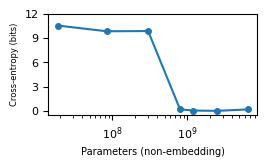

In [141]:
plt.figure(figsize=(2.5, 1.5))

i = 2
idx = monogenic_idxs[3][7]
plt.plot(no_emb_params, curves[idx]/np.log(2), 'o-', markersize=4)
plt.xscale('log')
plt.xlabel("Parameters (non-embedding)", fontsize=7)
plt.ylabel("Cross-entropy (bits)", fontsize=6)
plt.yticks([0, 3, 6, 9, 12], fontsize=8)
plt.xticks(fontsize=8)
print_context(idx)

plt.tight_layout(pad=0.1)
plt.savefig("../figures/tokenscaling/tokenessmarshall.pdf")

In [142]:
print(context_tokens(idx, 60))

['O', 'pinion', ' filed', ' March', ' 25', ',', ' 1988', '.', '\n', 'W', '.', 'Y', '.', ' Ch', 'alf', 'ant', ',', ' of', ' Br', 'anine', ',', ' Ch', 'alf', 'ant', ' &', ' Hill', ',', ' of', ' Hutch', 'inson', ',', ' argued', ' the', ' cause', ' and', ' was', ' on', ' the', ' brief', ' for', ' appellant', ',', ' H', 'es', 'ston', ' State', ' Bank', '.', '\n', 'Kenn', 'eth', ' C', '.', ' Jones', ',', ' of', ' Watson', ',', ' Ess', ',', ' Marshall']


In [143]:
before = 60
after = 5
tokens = context_tokens(idx, before, after=after)
text = tokens_to_latex(tokens, -(after+1))
with open("../texts/tokenpile/tokenessmarshall.tex", 'w') as f:
    f.write(text)

### Compute polygenic tokens

In [11]:
polygenics = []
for i in tqdm(range(100000)):
    xs = np.log(np.array(no_emb_params))
    ys = curves[i]
    model = LinearRegression().fit(xs.reshape(-1, 1), ys)
    if model.coef_[0] < -0.3 and model.score(xs.reshape(-1, 1), ys) > 0.98:
        polygenics.append(i)
        # print(i, model.coef_[0], model.score(xs.reshape(-1, 1), ys))
        # print_context(i)


  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
for i, idx in enumerate(polygenics):
    doc, l = get_context(idx)
    if doc['split_by_token'][l] == ' inf':
        print(i)
    if doc['split_by_token'][l] == ' normal':
        print(i)

18
43


Dectection of spinal cord lesion using skin electrode recordings of spinal evoked potential.
The multi-channel recording of somatosensory spinal evoked potential (SSEP) was carried out on 30 patients with various neurological disorders. In some cases, SSEP changes corresponded well with the lesioned level. In general, the lesions of thoraco-cervical level were difficult to detect, because the appearance rate of SSEP peaks are reduced over the thoraco-cervical spine even in normal


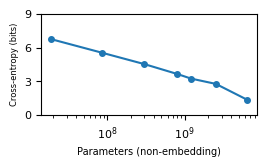

In [144]:
plt.figure(figsize=(2.5, 1.5))

i = 18
idx = polygenics[i]
plt.plot(no_emb_params, curves[idx]/np.log(2), 'o-', markersize=4)
plt.xscale('log')
plt.xlabel("Parameters (non-embedding)", fontsize=7)
plt.ylabel("Cross-entropy (bits)", fontsize=6)
plt.yticks([0, 3, 6, 9], fontsize=8)
plt.xticks(fontsize=8)
print_context(idx)

plt.tight_layout(pad=0.1)
plt.savefig("../figures/tokenscaling/tokenssep-normal.pdf")

In [145]:
print(context_tokens(idx, 40))

[' In', ' general', ',', ' the', ' lesions', ' of', ' thor', 'aco', '-', 'c', 'erv', 'ical', ' level', ' were', ' difficult', ' to', ' detect', ',', ' because', ' the', ' appearance', ' rate', ' of', ' S', 'SE', 'P', ' peaks', ' are', ' reduced', ' over', ' the', ' thor', 'aco', '-', 'c', 'erv', 'ical', ' spine', ' even', ' in', ' normal']


In [146]:
before = 40
after = 5
tokens = context_tokens(idx, before, after=after)
text = tokens_to_latex(tokens, -(after+1))
with open("../texts/tokenpile/tokenssep-normal.tex", 'w') as f:
    f.write(text)

Translate

Sunday, January 6, 2019

Summer, Glorious Summer!

My garden looks its best in the Summer. A lot of the plants I’ve selected for colour seem to be the ones that flower in summer, which is great because that’s when the garden gets the most use. The most obvious of these flowering plants would have to be the Bougainvillea Vine which I’ve trained to grow over a pergola. It’s a really nice place to sit as it provides a bit of shade from the harsh New Zealand sun.

The garden has changed quite a bit as it’s matured over the last few years, so I realised it was time to update the header on my Blog. I’ve been waiting for the Bougainvillea to be in full bloom so I could get a few nice photos. The header photo I decided to use was a panorama shot I took from the roof of the sleepout. This year the pergola was a great place to take a few family photos too.

One of the plants I’ve really enjoyed this year would have to be the Hydrangeas. I’ve tried propagating a few over the last coupl

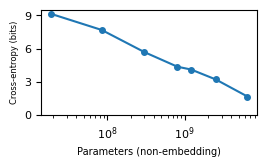

In [147]:
plt.figure(figsize=(2.5, 1.5))

i = 43
idx = polygenics[i]
plt.plot(no_emb_params, curves[idx]/np.log(2), 'o-', markersize=4)
plt.xscale('log')
plt.xlabel("Parameters (non-embedding)", fontsize=7)
plt.ylabel("Cross-entropy (bits)", fontsize=6)
plt.yticks([0, 3, 6, 9], fontsize=8)
plt.xticks(fontsize=8)
print_context(idx)

plt.tight_layout(pad=0.1)
plt.savefig("../figures/tokenscaling/tokenfruit-influx.pdf")

In [148]:
print(context_tokens(idx, 30))

['The', ' big', ' disappointment', ' this', ' summer', ' was', ' that', ' despite', ' my', ' 2', ' plum', ' trees', ' fru', 'iting', ' super', '-', 'ab', 'und', 'antly', ',', ' beyond', ' expectations', ',', ' the', ' fruit', ' was', ' mostly', ' spoiled', ' by', ' an', ' inf']


In [149]:
before = 30
after = 5
tokens = context_tokens(idx, before, after=after)
text = tokens_to_latex(tokens, -(after+1))
with open("../texts/tokenpile/tokenfruit-influx.tex", 'w') as f:
    f.write(text)

Mounting tensions with Syria sink US stocks

NEW YORK (AP) — Fears of an escalating conflict in Syria rippled across financial markets on Tuesday, sinking stocks, lifting gold and pushing the price of oil to the highest in a year and a half.

The increasing possibility of U.S. military strikes raised worries on Wall Street that energy trade in the region could be disrupted, raising fuel costs for consumers and business.

"If Syria becomes drawn out and becomes a long-term issue, it's going to show up in things like gas prices," said Chris Costanzo, investment officer with Tanglewood Wealth Management.

The Dow Jones industrial average fell 170.33 points, or 1.1 percent, to 14,776.13, the lowest in two months.

The Standard & Poor's 500 index lost 26.30 points, or 1.6 percent, to 1,630.48 and the Nasdaq composite fell 79.05 points, or 2.2 percent, to 3,578.52.

"The law of unintended consequences and the history of previous military interventions in the region is not a recipe for politi

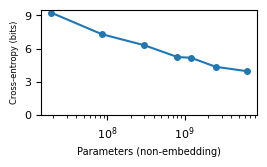

In [150]:
plt.figure(figsize=(2.5, 1.5))

i = 4
idx = polygenics[i]
plt.plot(no_emb_params, curves[idx]/np.log(2), 'o-', markersize=4)
plt.xscale('log')
plt.xlabel("Parameters (non-embedding)", fontsize=7)
plt.ylabel("Cross-entropy (bits)", fontsize=6)
plt.yticks([0, 3, 6, 9], fontsize=8)
plt.xticks(fontsize=8)
print_context(idx)

plt.tight_layout(pad=0.1)
plt.savefig("../figures/tokenscaling/tokenonconsumer.pdf")

In [151]:
print(context_tokens(idx, 53))

[' airline', ' by', ' revenue', ',', ' dropped', ' $', '2', '.', '15', ',', ' or', ' 7', '.', '2', ' percent', ',', ' to', ' $', '27', '.', '71', ' and', ' Delta', ' Air', ' Lines', ' lost', ' $', '1', '.', '16', ',', ' or', ' 5', '.', '7', ' percent', ',', ' to', ' $', '19', '.', '11', '.', '\n', '\n', 'Stone', ' said', ' oil', ' prices', ' could', ' start', ' weighing', ' on', ' consumer']


In [152]:
before = 53
after = 5
tokens = context_tokens(idx, before, after=after)
text = tokens_to_latex(tokens, -(after+1))
with open("../texts/tokenpile/tokenonconsumer.tex", 'w') as f:
    f.write(text)